In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm")
# torch_utils is needed from this path. 
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")

In [3]:
import json
from tqdm import tqdm
import re 
import glob
import os
from os.path import join
import torch
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from generate import edm_sampler
# from core.edm_utils import edm_sampler
# from train_edm import create_model, edm_sampler
from torchvision.utils import make_grid, save_image
from torchvision.transforms import ToPILImage

device = 'cuda'

In [4]:
train_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs"

In [5]:
!cd /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs ; du -sh *

240M	00004-afhqv2-64x64-uncond-ncsnpp-edm-gpus1-batch64-fp32
1.7G	00013-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch768-fp16
237M	00017-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
237M	00018-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch392-fp32
4.2G	00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
4.2G	00020-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00021-afhqv2-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00022-afhqv2-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00023-ffhq-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00024-ffhq-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00028-afhqv2-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32
6.5G	00029-ffhq-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32
3.3G	00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
3.3G	00031-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
12G	00032-cifar10-32x32-uncond-ddpmpp-edm-gpus4-batch256-fp32

In [6]:
import sys
sys.path.append("/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm")
def load_edm_model(ckptdir, ckpt_idx=-1, train_root=train_root, return_epoch=False):
    ckpt_list = glob.glob(join(train_root, ckptdir, "*.pkl"))
    ckpt_list = sorted(ckpt_list)
    ckpt_path = ckpt_list[ckpt_idx]
    epoch = int(re.findall(r'-(\d+).pkl', ckpt_path)[-1])
    print(f"Loading {ckpt_idx}th ckpt", ckpt_path)
    print("Epoch ", epoch)
    with open(ckpt_path, 'rb') as f:
        net = pkl.load(f)['ema'].to(device)
    if return_epoch:
        return net, epoch
    else:
        return net
    


def load_stats(ckptdir, train_root=train_root):
    train_stats = []
    with open(join(train_root, ckptdir, "stats.jsonl")) as f:
        for line in tqdm(f):
            train_stats.append(json.loads(line))
    return pd.DataFrame(train_stats)

### Load Datasets

In [7]:
from training.dataset import ImageFolderDataset

In [8]:
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/datasets

afhqv2-64x64-eigen.pt		  ffhq-64x64-eigen.pt
afhqv2-64x64-spectral-whiten.pt   ffhq-64x64-spectral-whiten.pt
afhqv2-64x64-whitened-nonorm.zip  ffhq-64x64-whitened-nonorm.zip
afhqv2-64x64-whitened.zip	  ffhq-64x64-whitened.zip
afhqv2-64x64.zip		  ffhq-64x64.zip
cifar10-32x32.zip


In [9]:
dataroot = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/datasets"
dataset_afhq = ImageFolderDataset(join(dataroot, "afhqv2-64x64.zip"))

In [10]:
Xtsr = np.stack([sample for sample, _ in dataset_afhq], axis=0) # (N, C, H, W)
Xtsr = torch.from_numpy(Xtsr)
Xtsr_norm = Xtsr / 127.5 - 1 # convention of edm model 
edm_Xmat = Xtsr_norm.view(Xtsr_norm.shape[0], -1)
edm_Xmat = edm_Xmat.to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = (edm_Xmat - edm_Xmean).T @ (edm_Xmat - edm_Xmean) / edm_Xmat.shape[0]
eigvals, eigvecs = torch.linalg.eigh(edm_Xcov)
eigvals = eigvals.flip(0)
eigvecs = eigvecs.flip(1)
edm_imgshape = Xtsr.shape[1:]
edm_std_mean = (torch.trace(edm_Xcov) / edm_Xcov.shape[0]).sqrt()

### Clustering structure of AFHQ

In [11]:
from core.analytical_score_lib import mean_isotropic_score, Gaussian_score, delta_GMM_score
from core.analytical_score_lib import explained_var_vec
from core.analytical_score_lib import sample_Xt_batch, sample_Xt_batch
from core.gaussian_mixture_lib import gaussian_mixture_score_batch_sigma_torch, \
    gaussian_mixture_lowrank_score_batch_sigma_torch, compute_cluster

In [12]:
kmeans_batch = 2048
kmeans_random_seed = 42
kmeans_verbose = 0
lambda_EPS = 1E-5
Us_col = {}
mus_col = {}
Lambdas_col = {}
weights_col = {}
for n_clusters in reversed([1, 2, 5, 10, 20,]): #  50, 100, 
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(edm_Xmat.cpu(), 
                            n_clusters=n_clusters,
                            kmeans_batch=kmeans_batch, 
                            kmeans_random_seed=kmeans_random_seed,
                            kmeans_verbose=kmeans_verbose,
                            lambda_EPS=lambda_EPS)
    Us_col[n_clusters] = eigvec_mat #.to(device)
    mus_col[n_clusters] = center_mat #.to(device)
    Lambdas_col[n_clusters] = eigval_mat #.to(device)
    weights = freq_vec / freq_vec.sum()
    weights_col[n_clusters] = weights #.to(device)
    print(f"n_clusters={n_clusters}, computed.")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  31556048.80640143


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.31s/it]


cov PCA completed for each cluster.
n_clusters=20, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  33712946.7767118


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.78s/it]


cov PCA completed for each cluster.
n_clusters=10, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  36387242.270318665


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


cov PCA completed for each cluster.
n_clusters=5, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  40646453.04290734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:43<00:00, 21.96s/it]


cov PCA completed for each cluster.
n_clusters=2, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  45597426.595639005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.37s/it]


cov PCA completed for each cluster.
n_clusters=1, computed.


### Compare model and anlytical scores

In [13]:
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs

00004-afhqv2-64x64-uncond-ncsnpp-edm-gpus1-batch64-fp32
00013-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch768-fp16
00017-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
00018-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch392-fp32
00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
00020-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
00021-afhqv2-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32
00022-afhqv2-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32
00023-ffhq-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32
00024-ffhq-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32
00028-afhqv2-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32
00029-ffhq-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32
00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
00031-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32
00032-cifar10-32x32-uncond-ddpmpp-edm-gpus4-batch256-fp32
00033-cifar10-32x32-cond-ddpmpp-edm-gpus4-batch256-fp32
00034-afhqv2-64x6

### Early initial run longer

In [14]:
from collections import defaultdict
from tqdm import trange
from functools import partial

In [15]:
ckptname = "00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
len(glob.glob(join(train_root, ckptname, "*.pkl")))
edm = load_edm_model(ckptname, ckpt_idx=-1,)
edm.to(device).eval();

Loading -1th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-005000.pkl
Epoch  5000


In [16]:
score_func_col = {
    "mean isotropic": lambda Xt, sigma: mean_isotropic_score(Xt, edm_Xmean, sigma).cpu(), 
    "mean + std isotropic": lambda Xt, sigma: mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean).cpu(), 
    "gaussian": lambda Xt, sigma: Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma).cpu(), 
    "gaussian regularize": lambda Xt, sigma: Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma).cpu(), 
    "gmm delta": lambda Xt, sigma: delta_GMM_score(Xt, edm_Xmat, sigma).cpu(), 
}
# for n_clusters in reversed([1, 2, 5, 10, 20,]): #  50, 100, 
#     score_func_col[f"gmm {n_clusters} mode"] = lambda Xt, sigma: gaussian_mixture_score_batch_sigma_torch(Xt, 
#                 mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
#                 weights=weights_col[n_clusters].cuda()).cpu()

In [17]:
ckptname = "00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
device = "cuda"
batch_size = 256
Nreps = 4
ckpt_num = len(glob.glob(join(train_root, ckptname, "*.pkl")))
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for ckpt_idx in trange(ckpt_num):
    edm, epoch = load_edm_model(ckptname, ckpt_idx=ckpt_idx, return_epoch=True)
    edm.to(device).eval();
    print(f"ckpt_idx={ckpt_idx}, epoch={epoch}")
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt_col = []
        score_vec_col = defaultdict(list)
        for rep in trange(Nreps, desc=f"sigma {sigma} rep"):
            Xt = sample_Xt_batch(edm_Xmat, batch_size, sigma=sigma).to(device)
            with torch.no_grad():
                edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma).cuda(), None, ).detach().cpu()
            edm_Dt = edm_Dt.view(Xt.shape)
            score_edm = (edm_Dt - Xt.cpu()) / (sigma**2)
            score_vec_col["EDM"].append(score_edm)
            Xt_col.append(Xt.cpu())
            for score_name, analy_score_func in score_func_col.items():
                score_vec_col[score_name].append(analy_score_func(Xt, sigma))
            for n_clusters in reversed([1, 2, 5, 10, 20,]): #  50, 100, 
                gmm_scores = gaussian_mixture_score_batch_sigma_torch(Xt, 
                    mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                    weights=weights_col[n_clusters].cuda()).cpu()
                score_vec_col[f"gmm_{n_clusters}_mode"].append(gmm_scores)
                torch.cuda.empty_cache()
        
        Xt_all = torch.cat(Xt_col, dim=0).cuda()
        for score_name, score_vec_list in score_vec_col.items():
            score_vec_col[score_name] = torch.cat(score_vec_list, dim=0)
        
        torch.cuda.empty_cache()
        
        score_edm = score_vec_col["EDM"].cuda()
        edm_Dt = score_edm * (sigma**2) + Xt_all
        for score_name, score in score_vec_col.items():
            score = score.to(device)
            Dnoiser = score * (sigma**2) + Xt_all
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col.append({"epoch": epoch, "sigma": sigma, "name": score_name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        torch.cuda.empty_cache()
        
    df_syn = pd.DataFrame(df_col)
    df_syn.to_csv("AFHQ_edm_5k_epoch_gmm_exp_var_part.csv")

df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("AFHQ_edm_5k_epoch_gmm_exp_var_fixed.csv")
df_syn.to_csv(join(train_root, ckptname, "AFHQ_edm_5k_epoch_gmm_exp_var_fixed.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                        | 0/51 [00:00<?, ?it/s]

Loading 0th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000000.pkl
Epoch  0
ckpt_idx=0, epoch=0



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.05s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.57s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.67s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.59s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 1th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000100.pkl
Epoch  100
ckpt_idx=1, epoch=100



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.54s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.48s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.55s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.49s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.56s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.71s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.58s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 2th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000200.pkl
Epoch  200
ckpt_idx=2, epoch=200



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.52s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.68s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.59s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.88s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.78s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 3th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000301.pkl
Epoch  301
ckpt_idx=3, epoch=301



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.62s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.62s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.75s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.47s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 4th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000401.pkl
Epoch  401
ckpt_idx=4, epoch=401



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.83s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.78s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.67s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.84s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.69s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 6th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000602.pkl
Epoch  602
ckpt_idx=6, epoch=602



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.56s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.88s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 7th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000702.pkl
Epoch  702
ckpt_idx=7, epoch=702



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.71s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.73s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.50s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 8th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000803.pkl
Epoch  803
ckpt_idx=8, epoch=803



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.69s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.79s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.84s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.84s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.58s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 9th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000903.pkl
Epoch  903
ckpt_idx=9, epoch=903



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.54s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.75s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.67s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 10th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001003.pkl
Epoch  1003
ckpt_idx=10, epoch=1003



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.84s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.84s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.66s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.88s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 11th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001104.pkl
Epoch  1104
ckpt_idx=11, epoch=1104



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.73s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.56s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.75s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 12th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001204.pkl
Epoch  1204
ckpt_idx=12, epoch=1204



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.78s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.51s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 13th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001304.pkl
Epoch  1304
ckpt_idx=13, epoch=1304



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.86s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.89s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.68s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.67s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 14th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001405.pkl
Epoch  1405
ckpt_idx=14, epoch=1405



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.71s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.83s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.66s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 15th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001505.pkl
Epoch  1505
ckpt_idx=15, epoch=1505



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.69s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.54s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.66s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.59s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.68s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.57s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 16th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001605.pkl
Epoch  1605
ckpt_idx=16, epoch=1605



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.92s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.75s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.78s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.77s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.75

Loading 43th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004315.pkl
Epoch  4315
ckpt_idx=43, epoch=4315



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.57s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.47s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.37s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.58s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.77s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.79s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 44th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004415.pkl
Epoch  4415
ckpt_idx=44, epoch=4415



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.90s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.82s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.91s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.68s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.94s/it]

sigma 2.0 rep: 100%|█████████████████████████████████████████

Loading 45th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004516.pkl
Epoch  4516
ckpt_idx=45, epoch=4516



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.77s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.63s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.61s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.85s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.86s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 46th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004616.pkl
Epoch  4616
ckpt_idx=46, epoch=4616



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.79s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.77s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.95s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.80s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.80s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.80s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 47th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004716.pkl
Epoch  4716
ckpt_idx=47, epoch=4716



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.82s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.74s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.56s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.44s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.61s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 48th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004817.pkl
Epoch  4817
ckpt_idx=48, epoch=4817



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.62s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.69s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.64s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.86s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.79s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.81s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.83s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 49th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004917.pkl
Epoch  4917
ckpt_idx=49, epoch=4917



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.75s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.75s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.52s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.70s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.62s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.76s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

Loading 50th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-005000.pkl
Epoch  5000
ckpt_idx=50, epoch=5000



sigma 0.01 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.91s/it]

sigma 0.02 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.78s/it]

sigma 0.05 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.83s/it]

sigma 0.1 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.89s/it]

sigma 0.2 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.65s/it]

sigma 0.5 rep: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.73s/it]

sigma 0.75 rep: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.80s/it]

sigma 1.0 rep: 100%|█████████████████████████████████████████

In [28]:
df_syn

,epoch,sigma,name,St_EV,St_EV_std,St_EV_rev,St_EV_rev_std,Dt_EV,Dt_EV_std,Dt_EV_rev,Dt_EV_rev_std,St_Var,St_Var_std,Dt_Var,Dt_Var_std,St_residual,St_rev_residual,Dt_residual,Dt_rev_residual
0,5000,0.01,EDM,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,4.809524e+07,1.196457e+07,2966.744629,1244.688354,0.000000e+00,0.000000e+00,0.000000,0.000000
1,5000,0.01,mean_isotropic,-6091.224121,3.137001e+03,0.000946,4.084683e-04,0.061692,0.154574,-12.005547,5.806489,2.770602e+11,1.235908e+11,212.862717,0.000028,6.092224e+03,9.990541e-01,0.938308,13.005547
2,5000,0.01,mean + std isotropic,0.001383,9.119467e-04,-1123.424561,5.457305e+02,0.999811,0.000091,0.999811,0.000091,5.021245e+04,2.239873e+04,2966.556152,1243.655151,9.986167e-01,1.124425e+03,0.000189,0.000189
3,5000,0.01,gaussian,0.408096,1.215191e-01,0.182142,1.489323e-01,0.999894,0.000044,0.999894,0.000044,3.358081e+07,1.753678e+06,2966.817627,1244.666382,5.919040e-01,8.178576e-01,0.000106,0.000106
4,5000,0.01,gaussian regularize,0.425927,4.105746e-02,-1.106336,6.107775e-01,0.999893,0.000049,0.999893,0.000049,1.317959e+07,9.461111e+05,2967.026855,1244.666626,5.740731e-01,2.106336e+00,0.000107,0.000107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,5000,80.00,gmm 20 mode,0.999999,3.931415e-07,0.999999,3.932345e-07,0.849821,0.070289,0.746184,0.175659,1.920946e+00,2.222267e-02,280.370307,137.231428,7.509386e-07,7.511598e-07,0.150179,0.253816
172,5000,80.00,gmm 10 mode,0.999999,4.110275e-07,0.999999,4.111244e-07,0.849658,0.069977,0.743170,0.179507,1.920947e+00,2.222262e-02,279.186263,138.296449,7.573890e-07,7.576113e-07,0.150342,0.256830
173,5000,80.00,gmm 5 mode,0.999999,3.853244e-07,0.999999,3.854141e-07,0.852437,0.059969,0.733271,0.162284,1.920946e+00,2.222254e-02,259.126312,130.123180,7.538480e-07,7.540702e-07,0.147563,0.266729
174,5000,80.00,gmm 2 mode,0.999999,4.057945e-07,0.999999,4.058889e-07,0.851693,0.066772,0.742609,0.176714,1.920946e+00,2.222286e-02,276.330645,139.398220,7.492076e-07,7.494278e-07,0.148307,0.257391


### Obsolete version with some errors... wasting time

In [19]:
ckptname = "00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
device = "cuda"
batch_size = 256
ckpt_num = len(glob.glob(join(train_root, ckptname, "*.pkl")))
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for ckpt_idx in trange(ckpt_num):
    edm, epoch = load_edm_model(ckptname, ckpt_idx=ckpt_idx, return_epoch=True)
    edm.to(device).eval();
    print(f"ckpt_idx={ckpt_idx}, epoch={epoch}")
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        score_vec_col = defaultdict(list)
        Xt_col = []
        for rep in trange(8, desc=f"sigma {sigma} rep"):
            Xt = sample_Xt_batch(edm_Xmat, batch_size, sigma=sigma).to(device)
            with torch.no_grad():
                edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma).cuda(), None, ).detach().cpu()
            edm_Dt = edm_Dt.view(Xt.shape)
            score_edm = (edm_Dt - Xt.cpu()) / (sigma**2)
            score_vec_col["EDM"].append(score_edm)
            Xt_col.append(Xt.cpu())
            for score_name, analy_score_func in score_func_col.items():
                score_vec_col[score_name].append(analy_score_func(Xt, sigma))
        
        torch.cuda.empty_cache()
        Xt_all = torch.cat(Xt_col, dim=0).cuda()
        for score_name, score_vec_list in score_vec_col.items():
            score_vec_col[score_name] = torch.cat(score_vec_list, dim=0)
        
        torch.cuda.empty_cache()
        
        score_edm = score_vec_col["EDM"].cuda()
        edm_Dt = score_edm * (sigma**2) + Xt_all
        for score_name, score in score_vec_col.items():
            score = score.to(device)
            Dnoiser = score * (sigma**2) + Xt_all
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col.append({"epoch": epoch, "sigma": sigma, "name": score_name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        torch.cuda.empty_cache()

df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("AFHQ_edm_5k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(train_root, ckptname, "AFHQ_edm_5k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/51 [00:00<?, ?it/s]

Loading 0th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000000.pkl
Epoch  0
ckpt_idx=0, epoch=0


  2%|█▉                                                                                               | 1/51 [04:55<4:05:51, 295.03s/it]

Loading 1th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000100.pkl
Epoch  100
ckpt_idx=1, epoch=100


  4%|███▊                                                                                             | 2/51 [09:49<4:00:31, 294.51s/it]

Loading 2th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000200.pkl
Epoch  200
ckpt_idx=2, epoch=200


  6%|█████▋                                                                                           | 3/51 [14:42<3:55:01, 293.79s/it]

Loading 3th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000301.pkl
Epoch  301
ckpt_idx=3, epoch=301


  8%|███████▌                                                                                         | 4/51 [19:35<3:50:05, 293.73s/it]

Loading 4th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000401.pkl
Epoch  401
ckpt_idx=4, epoch=401


 10%|█████████▌                                                                                       | 5/51 [24:28<3:44:58, 293.45s/it]

Loading 5th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000502.pkl
Epoch  502
ckpt_idx=5, epoch=502


 12%|███████████▍                                                                                     | 6/51 [29:20<3:39:44, 292.99s/it]

Loading 6th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000602.pkl
Epoch  602
ckpt_idx=6, epoch=602


 14%|█████████████▎                                                                                   | 7/51 [34:14<3:34:56, 293.09s/it]

Loading 7th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000702.pkl
Epoch  702
ckpt_idx=7, epoch=702


 16%|███████████████▏                                                                                 | 8/51 [39:06<3:29:58, 292.99s/it]

Loading 8th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000803.pkl
Epoch  803
ckpt_idx=8, epoch=803


 18%|█████████████████                                                                                | 9/51 [43:59<3:25:06, 293.01s/it]

Loading 9th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000903.pkl
Epoch  903
ckpt_idx=9, epoch=903


 20%|██████████████████▊                                                                             | 10/51 [48:53<3:20:23, 293.27s/it]

Loading 10th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001003.pkl
Epoch  1003
ckpt_idx=10, epoch=1003


 22%|████████████████████▋                                                                           | 11/51 [53:47<3:15:36, 293.41s/it]

Loading 11th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001104.pkl
Epoch  1104
ckpt_idx=11, epoch=1104


 24%|██████████████████████▌                                                                         | 12/51 [58:41<3:10:52, 293.66s/it]

Loading 12th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001204.pkl
Epoch  1204
ckpt_idx=12, epoch=1204


 25%|███████████████████████▉                                                                      | 13/51 [1:03:35<3:06:00, 293.69s/it]

Loading 13th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001304.pkl
Epoch  1304
ckpt_idx=13, epoch=1304


 27%|█████████████████████████▊                                                                    | 14/51 [1:08:28<3:01:03, 293.60s/it]

Loading 14th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001405.pkl
Epoch  1405
ckpt_idx=14, epoch=1405


 29%|███████████████████████████▋                                                                  | 15/51 [1:13:21<2:55:58, 293.28s/it]

Loading 15th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001505.pkl
Epoch  1505
ckpt_idx=15, epoch=1505


 31%|█████████████████████████████▍                                                                | 16/51 [1:18:14<2:51:01, 293.19s/it]

Loading 16th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001605.pkl
Epoch  1605
ckpt_idx=16, epoch=1605


 33%|███████████████████████████████▎                                                              | 17/51 [1:23:07<2:46:11, 293.29s/it]

Loading 17th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001706.pkl
Epoch  1706
ckpt_idx=17, epoch=1706


 35%|█████████████████████████████████▏                                                            | 18/51 [1:28:01<2:41:22, 293.42s/it]

Loading 18th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001806.pkl
Epoch  1806
ckpt_idx=18, epoch=1806


 37%|███████████████████████████████████                                                           | 19/51 [1:32:55<2:36:35, 293.61s/it]

Loading 19th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001906.pkl
Epoch  1906
ckpt_idx=19, epoch=1906


 39%|████████████████████████████████████▊                                                         | 20/51 [1:37:49<2:31:40, 293.56s/it]

Loading 20th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002007.pkl
Epoch  2007
ckpt_idx=20, epoch=2007


 41%|██████████████████████████████████████▋                                                       | 21/51 [1:42:42<2:26:41, 293.39s/it]

Loading 21th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002107.pkl
Epoch  2107
ckpt_idx=21, epoch=2107


 43%|████████████████████████████████████████▌                                                     | 22/51 [1:47:33<2:21:34, 292.92s/it]

Loading 22th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002208.pkl
Epoch  2208
ckpt_idx=22, epoch=2208


 45%|██████████████████████████████████████████▍                                                   | 23/51 [1:52:27<2:16:45, 293.05s/it]

Loading 23th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002308.pkl
Epoch  2308
ckpt_idx=23, epoch=2308


 47%|████████████████████████████████████████████▏                                                 | 24/51 [1:57:20<2:11:54, 293.12s/it]

Loading 24th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002408.pkl
Epoch  2408
ckpt_idx=24, epoch=2408


 49%|██████████████████████████████████████████████                                                | 25/51 [2:02:13<2:07:01, 293.15s/it]

Loading 25th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002509.pkl
Epoch  2509
ckpt_idx=25, epoch=2509


 51%|███████████████████████████████████████████████▉                                              | 26/51 [2:07:05<2:02:01, 292.86s/it]

Loading 26th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002609.pkl
Epoch  2609
ckpt_idx=26, epoch=2609


 53%|█████████████████████████████████████████████████▊                                            | 27/51 [2:11:58<1:57:06, 292.78s/it]

Loading 27th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002709.pkl
Epoch  2709
ckpt_idx=27, epoch=2709


 55%|███████████████████████████████████████████████████▌                                          | 28/51 [2:16:53<1:52:25, 293.28s/it]

Loading 28th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002810.pkl
Epoch  2810
ckpt_idx=28, epoch=2810


 57%|█████████████████████████████████████████████████████▍                                        | 29/51 [2:21:46<1:47:36, 293.49s/it]

Loading 29th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-002910.pkl
Epoch  2910
ckpt_idx=29, epoch=2910


 59%|███████████████████████████████████████████████████████▎                                      | 30/51 [2:26:40<1:42:43, 293.50s/it]

Loading 30th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003010.pkl
Epoch  3010
ckpt_idx=30, epoch=3010


 61%|█████████████████████████████████████████████████████████▏                                    | 31/51 [2:31:33<1:37:45, 293.26s/it]

Loading 31th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003111.pkl
Epoch  3111
ckpt_idx=31, epoch=3111


 63%|██████████████████████████████████████████████████████████▉                                   | 32/51 [2:36:27<1:32:55, 293.45s/it]

Loading 32th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003211.pkl
Epoch  3211
ckpt_idx=32, epoch=3211


 65%|████████████████████████████████████████████████████████████▊                                 | 33/51 [2:41:20<1:28:00, 293.34s/it]

Loading 33th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003311.pkl
Epoch  3311
ckpt_idx=33, epoch=3311


 67%|██████████████████████████████████████████████████████████████▋                               | 34/51 [2:46:12<1:23:03, 293.17s/it]

Loading 34th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003412.pkl
Epoch  3412
ckpt_idx=34, epoch=3412


 69%|████████████████████████████████████████████████████████████████▌                             | 35/51 [2:51:06<1:18:10, 293.15s/it]

Loading 35th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003512.pkl
Epoch  3512
ckpt_idx=35, epoch=3512


 71%|██████████████████████████████████████████████████████████████████▎                           | 36/51 [2:55:58<1:13:15, 293.05s/it]

Loading 36th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003612.pkl
Epoch  3612
ckpt_idx=36, epoch=3612


 73%|████████████████████████████████████████████████████████████████████▏                         | 37/51 [3:00:52<1:08:26, 293.30s/it]

Loading 37th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003713.pkl
Epoch  3713
ckpt_idx=37, epoch=3713


 75%|██████████████████████████████████████████████████████████████████████                        | 38/51 [3:05:46<1:03:33, 293.31s/it]

Loading 38th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003813.pkl
Epoch  3813
ckpt_idx=38, epoch=3813


 76%|█████████████████████████████████████████████████████████████████████████▍                      | 39/51 [3:10:39<58:39, 293.32s/it]

Loading 39th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-003913.pkl
Epoch  3913
ckpt_idx=39, epoch=3913


 78%|███████████████████████████████████████████████████████████████████████████▎                    | 40/51 [3:15:32<53:44, 293.14s/it]

Loading 40th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004014.pkl
Epoch  4014
ckpt_idx=40, epoch=4014


 80%|█████████████████████████████████████████████████████████████████████████████▏                  | 41/51 [3:20:29<49:05, 294.54s/it]

Loading 41th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004114.pkl
Epoch  4114
ckpt_idx=41, epoch=4114


 82%|███████████████████████████████████████████████████████████████████████████████                 | 42/51 [3:25:27<44:18, 295.35s/it]

Loading 42th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004215.pkl
Epoch  4215
ckpt_idx=42, epoch=4215


 84%|████████████████████████████████████████████████████████████████████████████████▉               | 43/51 [3:30:27<39:34, 296.84s/it]

Loading 43th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004315.pkl
Epoch  4315
ckpt_idx=43, epoch=4315


 86%|██████████████████████████████████████████████████████████████████████████████████▊             | 44/51 [3:35:28<34:46, 298.09s/it]

Loading 44th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004415.pkl
Epoch  4415
ckpt_idx=44, epoch=4415


 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 45/51 [3:40:27<29:50, 298.35s/it]

Loading 45th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004516.pkl
Epoch  4516
ckpt_idx=45, epoch=4516


 90%|██████████████████████████████████████████████████████████████████████████████████████▌         | 46/51 [3:45:22<24:47, 297.42s/it]

Loading 46th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004616.pkl
Epoch  4616
ckpt_idx=46, epoch=4616


 92%|████████████████████████████████████████████████████████████████████████████████████████▍       | 47/51 [3:50:18<19:48, 297.04s/it]

Loading 47th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004716.pkl
Epoch  4716
ckpt_idx=47, epoch=4716


 94%|██████████████████████████████████████████████████████████████████████████████████████████▎     | 48/51 [3:55:13<14:49, 296.44s/it]

Loading 48th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004817.pkl
Epoch  4817
ckpt_idx=48, epoch=4817


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 49/51 [4:00:07<09:51, 295.72s/it]

Loading 49th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-004917.pkl
Epoch  4917
ckpt_idx=49, epoch=4917


 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 50/51 [4:05:02<04:55, 295.31s/it]

Loading 50th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-005000.pkl
Epoch  5000
ckpt_idx=50, epoch=5000


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [4:09:54<00:00, 294.02s/it]


In [ ]:
# ckptname = "00034-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
# device = "cuda"
# ckpt_num = len(glob.glob(join(train_root, ckptname, "*.pkl")))
# print("Explaining EDM score with GMM and other analytical scores")
# df_col = []
# for ckpt_idx in tqdm(range(ckpt_num)):
#     edm, epoch = load_edm_model(ckptname, ckpt_idx=ckpt_idx, return_epoch=True)
#     edm.to(device).eval();
#     print(f"ckpt_idx={ckpt_idx}, epoch={epoch}")
#     for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
#         Xt = sample_Xt_batch(edm_Xmat, 256, sigma=sigma)
#         edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma).cuda(), None, ).detach()
#         edm_Dt = edm_Dt.view(Xt.shape)
#         score_edm = (edm_Dt - Xt) / (sigma**2)
#         score_K_gmm_Xt = {}
#         for n_clusters in [*mus_col.keys()]:
#             score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
#                 mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
#                 weights=weights_col[n_clusters].cuda(), ).cpu()
#         torch.cuda.empty_cache()
#         score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma).cpu()
#         score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean).cpu()
#         score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma).cpu()
#         score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma).cpu()
#         score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma).cpu()
#         # Dt_gmm = score_gmm_Xt * (sigma**2) + Xt.cpu()
#         print(f"sigma={sigma}")
#         df_col_part = []
#         for name, score in [("EDM", score_edm), 
#                         ("mean isotropic", score_mean_Xt), 
#                         ("mean + std isotropic", score_mean_std_Xt), 
#                         ("gaussian", score_gaussian_Xt), 
#                         ("gaussian regularize", score_gaussian_reg_Xt),
#                         *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
#                           for n_clusters in sorted([*mus_col.keys()])],
#                         ("gmm delta", score_gmm_Xt),
#                         ]:
#             score = score.to(device)
#             Dnoiser = score * (sigma**2) + Xt
#             exp_var_vec = explained_var_vec(score_edm, score)
#             exp_var_rev_vec = explained_var_vec(score, score_edm)
#             exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
#             exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
#             St_var_vec = score.pow(2).sum(dim=1)
#             Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
#             df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
#                         "St_EV": exp_var_vec.mean().item(), 
#                         "St_EV_std": exp_var_vec.std().item(),
#                         "St_EV_rev": exp_var_rev_vec.mean().item(), 
#                         "St_EV_rev_std": exp_var_rev_vec.std().item(),
#                         "Dt_EV": exp_var_vec_Dt.mean().item(), 
#                         "Dt_EV_std": exp_var_vec_Dt.std().item(),
#                         "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
#                         "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
#                         "St_Var": St_var_vec.mean().item(),
#                         "St_Var_std": St_var_vec.std().item(),
#                         "Dt_Var": Dt_var_vec.mean().item(), 
#                         "Dt_Var_std": Dt_var_vec.std().item(),})
#         df_col.extend(df_col_part)
#         torch.cuda.empty_cache()
# df_syn = pd.DataFrame(df_col)
# df_syn["St_residual"] = 1 - df_syn["St_EV"]
# df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
# df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
# df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
# df_syn.to_csv("AFHQ_edm_5k_epoch_gmm_exp_var.csv")
# df_syn.to_csv(join(train_root, ckptdir, "AFHQ_edm_5k_epoch_gmm_exp_var.csv"))

### Early initial run 1

In [31]:
ckptname = "00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
device = "cuda"
ckpt_num = len(glob.glob(join(train_root, ckptname, "*.pkl")))
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for ckpt_idx in tqdm(range(ckpt_num)):
    edm, epoch = load_edm_model(ckptname, ckpt_idx=ckpt_idx, return_epoch=True)
    edm.to(device).eval();
    print(f"ckpt_idx={ckpt_idx}, epoch={epoch}")
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 256, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma).cuda(), None, ).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_K_gmm_Xt = {}
        for n_clusters in [*mus_col.keys()]:
            score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
                mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                weights=weights_col[n_clusters].cuda(), ).cpu()
        torch.cuda.empty_cache()
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma).cpu()
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean).cpu()
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma).cpu()
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma).cpu()
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma).cpu()
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt.cpu()
        print(f"sigma={sigma}")
        df_col_part = []
        for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
                          for n_clusters in sorted([*mus_col.keys()])],
                        ("gmm delta", score_gmm_Xt),
                        ]:
            score = score.to(device)
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        df_col.extend(df_col_part)
        torch.cuda.empty_cache()
df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("AFHQ_edm_1k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(train_root, ckptdir, "AFHQ_edm_25k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/11 [00:00<?, ?it/s]

Loading 0th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000000.pkl
Epoch  0
ckpt_idx=0, epoch=0
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


  9%|█████████                                                                                          | 1/11 [02:03<20:34, 123.42s/it]

sigma=80.0
Loading 1th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000100.pkl
Epoch  100
ckpt_idx=1, epoch=100
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 18%|██████████████████                                                                                 | 2/11 [04:07<18:34, 123.86s/it]

sigma=80.0
Loading 2th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000200.pkl
Epoch  200
ckpt_idx=2, epoch=200
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 27%|██████████████████████████▉                                                                        | 3/11 [06:12<16:34, 124.26s/it]

sigma=80.0
Loading 3th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000301.pkl
Epoch  301
ckpt_idx=3, epoch=301
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 36%|████████████████████████████████████                                                               | 4/11 [08:16<14:30, 124.33s/it]

sigma=80.0
Loading 4th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000401.pkl
Epoch  401
ckpt_idx=4, epoch=401
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 45%|█████████████████████████████████████████████                                                      | 5/11 [10:21<12:25, 124.31s/it]

sigma=80.0
Loading 5th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000502.pkl
Epoch  502
ckpt_idx=5, epoch=502
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 55%|█████████████████████████████████████████████████████▉                                             | 6/11 [12:25<10:20, 124.19s/it]

sigma=80.0
Loading 6th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000602.pkl
Epoch  602
ckpt_idx=6, epoch=602
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 64%|███████████████████████████████████████████████████████████████                                    | 7/11 [14:28<08:15, 123.83s/it]

sigma=80.0
Loading 7th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000702.pkl
Epoch  702
ckpt_idx=7, epoch=702
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 73%|████████████████████████████████████████████████████████████████████████                           | 8/11 [16:31<06:11, 123.80s/it]

sigma=80.0
Loading 8th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000803.pkl
Epoch  803
ckpt_idx=8, epoch=803
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 82%|█████████████████████████████████████████████████████████████████████████████████                  | 9/11 [18:35<04:07, 123.64s/it]

sigma=80.0
Loading 9th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000903.pkl
Epoch  903
ckpt_idx=9, epoch=903
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 10/11 [20:40<02:04, 124.05s/it]

sigma=80.0
Loading 10th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-001000.pkl
Epoch  1000
ckpt_idx=10, epoch=1000
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [22:43<00:00, 123.96s/it]

sigma=80.0


### Exploration

In [22]:
# ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207/checkpoints/"
# epoch = 2500 # 49999
# config = get_default_config("mnist")
# edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
    Xt = sample_Xt_batch(edm_Xmat, 256, sigma=sigma)
    with torch.no_grad():
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma).cuda(), None, ).detach() # use_ema=False
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_K_gmm_Xt = {}
    for n_clusters in [*mus_col.keys()]:
        score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
            mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
            weights=weights_col[n_clusters].cuda(), )
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
                          for n_clusters in score_K_gmm_Xt],
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    torch.cuda.empty_cache()
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
   sigma                  name          St_EV  St_EV_rev     Dt_EV  Dt_EV_rev
0   0.01                   EDM       1.000000   1.000000  1.000000   1.000000
1   0.01        mean isotropic -511481.750000  -0.001683  0.069462 -12.165503
2   0.01  mean + std isotropic      -0.438660 -16.035141  0.999997   0.999997
3   0.01              gaussian     -68.188721  -0.015213  0.999869   0.999869
4   0.01   gaussian regularize     -26.819939  -0.040094  0.999947   0.999947
5   0.01             gmm delta    -247.231140  -0.004037  0.999529   0.999528
sigma=0.02
   sigma                  name          St_EV  St_EV_rev     Dt_EV  Dt_EV_rev
0   0.02                   EDM       1.000000   1.000000  1.000000   1.000000
1   0.02        mean isotropic -161474.718750  -0.002543  0.062605 -12.467638
2   0.02  mean + std isotropic      -1.120086  -4.024801  0.999987   0.999986
3   0.02              gaussian    -121.781143  -0.002324  0.99

21it [00:00, 30626.00it/s]


<Axes: >

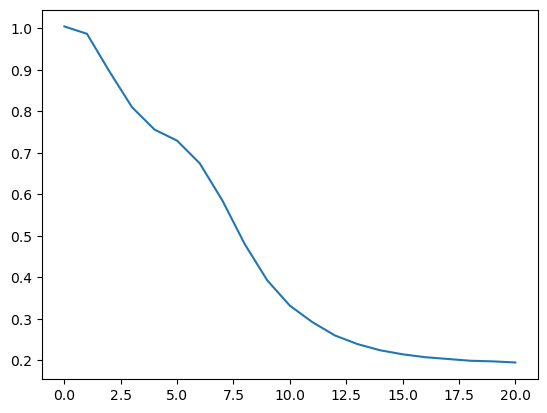

In [31]:
ckptdir = "00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
train_stats = load_stats(ckptdir)
train_stats["Loss/loss"].map(lambda x: x["mean"]).plot()

Loading 1th ckpt /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00030-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32/network-snapshot-000100.pkl
Epoch  100


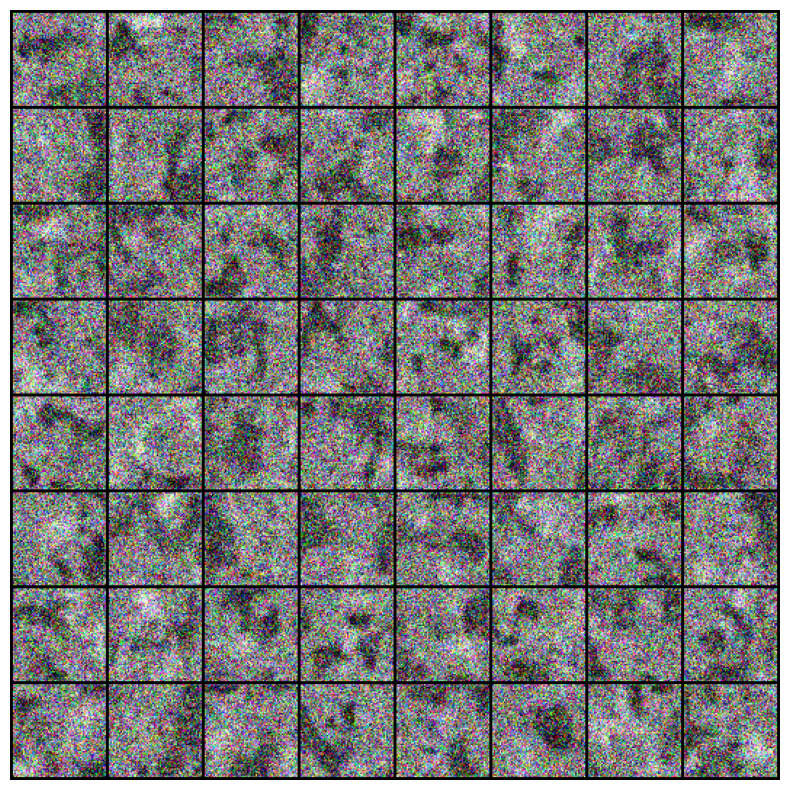

In [43]:
net = load_edm_model(ckptdir, ckpt_idx=1,)
# Create a grid of images
batch_size = 64
latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], 
                    device=device)
samples = edm_sampler(net, latents, num_steps=35, )
# samples = (samples.clamp(-1, 1) + 1) / 2
samples = (samples * 127.5 + 128).clip(0, 255) / 255.0
grid = make_grid(samples.cpu(), nrow=8, normalize=True)
# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [92]:
!ls /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/edm/training-runs/00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32

log.txt			     network-snapshot-022579.pkl
network-snapshot-000000.pkl  network-snapshot-025088.pkl
network-snapshot-002509.pkl  network-snapshot-027597.pkl
network-snapshot-005017.pkl  network-snapshot-030105.pkl
network-snapshot-007526.pkl  network-snapshot-032614.pkl
network-snapshot-010035.pkl  network-snapshot-035123.pkl
network-snapshot-012544.pkl  stats.jsonl
network-snapshot-015053.pkl  training_options.json
network-snapshot-017561.pkl  training-state-025088.pt
network-snapshot-020070.pkl


707it [00:00, 70211.27it/s]

<Axes: >

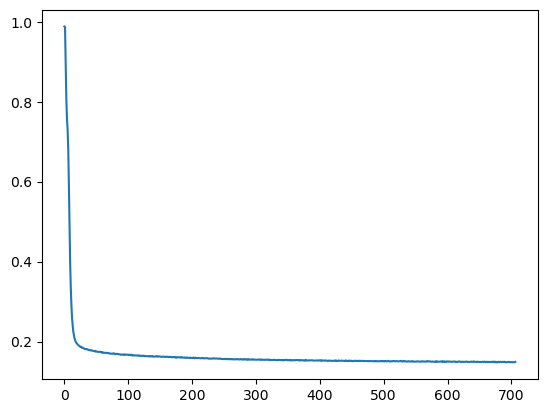

In [23]:
ckptdir = "00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32"
train_stats = load_stats(ckptdir)
train_stats["Loss/loss"].map(lambda x: x["mean"]).plot()

## Spectral Whiten Models 

In [26]:
sorted(os.listdir(train_root))

['00004-afhqv2-64x64-uncond-ncsnpp-edm-gpus1-batch64-fp32',
 '00008-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch4-fp32',
 '00011-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch8-fp16',
 '00012-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch256-fp16',
 '00013-afhqv2-64x64-uncond-ncsnpp-edm-gpus4-batch768-fp16',
 '00017-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00018-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch392-fp32',
 '00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00020-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00021-afhqv2-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00022-afhqv2-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00023-ffhq-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00024-ffhq-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00028-afhqv2-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00029-ffhq-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32']

In [27]:
train_stats

,Loss/loss,Progress/tick,Progress/kimg,Timing/total_sec,Timing/sec_per_tick,Timing/sec_per_kimg,Timing/maintenance_sec,Resources/cpu_mem_gb,Resources/peak_gpu_mem_gb,Resources/peak_gpu_mem_reserved_gb,timestamp
0,"{'num': 3145728, 'mean': 1.6964410940806072, '...","{'num': 1, 'mean': 0.0, 'std': 0.0}","{'num': 1, 'mean': 0.25600001215934753, 'std':...","{'num': 1, 'mean': 29.674842834472656, 'std': ...","{'num': 1, 'mean': 14.194101333618164, 'std': ...","{'num': 1, 'mean': 55.445709228515625, 'std': ...","{'num': 1, 'mean': 15.480741500854492, 'std': ...","{'num': 1, 'mean': 2.1108779907226562, 'std': ...","{'num': 1, 'mean': 24.855844497680664, 'std': ...","{'num': 1, 'mean': 27.0546875, 'std': 0.0}",1.695365e+09
1,"{'num': 616562688, 'mean': 1.692470090324376, ...","{'num': 1, 'mean': 1.0, 'std': 0.0}","{'num': 1, 'mean': 50.43199920654297, 'std': 0.0}","{'num': 1, 'mean': 154.5857696533203, 'std': 0.0}","{'num': 1, 'mean': 122.12417602539062, 'std': ...","{'num': 1, 'mean': 2.4339160919189453, 'std': ...","{'num': 1, 'mean': 2.7867560386657715, 'std': ...","{'num': 1, 'mean': 2.5816574096679688, 'std': ...","{'num': 1, 'mean': 20.68939971923828, 'std': 0.0}","{'num': 1, 'mean': 22.392578125, 'std': 0.0}",1.695365e+09
2,"{'num': 616562688, 'mean': 1.6705487498215266,...","{'num': 1, 'mean': 2.0, 'std': 0.0}","{'num': 1, 'mean': 100.60800170898438, 'std': ...","{'num': 1, 'mean': 276.7005310058594, 'std': 0.0}","{'num': 1, 'mean': 122.10417175292969, 'std': ...","{'num': 1, 'mean': 2.4335174560546875, 'std': ...","{'num': 1, 'mean': 0.010591983795166016, 'std'...","{'num': 1, 'mean': 2.5816574096679688, 'std': ...","{'num': 1, 'mean': 20.689455032348633, 'std': ...","{'num': 1, 'mean': 22.392578125, 'std': 0.0}",1.695365e+09
3,"{'num': 616562688, 'mean': 1.616183834011052, ...","{'num': 1, 'mean': 3.0, 'std': 0.0}","{'num': 1, 'mean': 150.78399658203125, 'std': ...","{'num': 1, 'mean': 398.8290710449219, 'std': 0.0}","{'num': 1, 'mean': 122.1179428100586, 'std': 0.0}","{'num': 1, 'mean': 2.4337918758392334, 'std': ...","{'num': 1, 'mean': 0.010590076446533203, 'std'...","{'num': 1, 'mean': 2.5816574096679688, 'std': ...","{'num': 1, 'mean': 20.689498901367188, 'std': ...","{'num': 1, 'mean': 22.392578125, 'std': 0.0}",1.695365e+09
4,"{'num': 616562688, 'mean': 1.5429024323314227,...","{'num': 1, 'mean': 4.0, 'std': 0.0}","{'num': 1, 'mean': 200.9600067138672, 'std': 0.0}","{'num': 1, 'mean': 520.7731323242188, 'std': 0.0}","{'num': 1, 'mean': 121.93379211425781, 'std': ...","{'num': 1, 'mean': 2.430121660232544, 'std': 0.0}","{'num': 1, 'mean': 0.010273456573486328, 'std'...","{'num': 1, 'mean': 2.5816612243652344, 'std': ...","{'num': 1, 'mean': 20.689533233642578, 'std': ...","{'num': 1, 'mean': 22.392578125, 'std': 0.0}",1.695365e+09
...,...,...,...,...,...,...,...,...,...,...,...
1061,"{'num': 616562688, 'mean': 1.136570119330672, ...","{'num': 1, 'mean': 1061.0, 'std': 0.0}","{'num': 1, 'mean': 53236.9921875, 'std': 0.0}","{'num': 1, 'mean': 129068.2109375, 'std': 0.0}","{'num': 1, 'mean': 121.3983154296875, 'std': 0.0}","{'num': 1, 'mean': 2.419449806213379, 'std': 0.0}","{'num': 1, 'mean': 0.009813070297241211, 'std'...","{'num': 1, 'mean': 2.6302566528320312, 'std': ...","{'num': 1, 'mean': 20.69070053100586, 'std': 0.0}","{'num': 1, 'mean': 22.39453125, 'std': 0.0}",1.695494e+09
1062,"{'num': 616562688, 'mean': 1.1400154224869345,...","{'num': 1, 'mean': 1062.0, 'std': 0.0}","{'num': 1, 'mean': 53287.16796875, 'std': 0.0}","{'num': 1, 'mean': 129189.578125, 'std': 0.0}","{'num': 1, 'mean': 121.35881042480469, 'std': ...","{'num': 1, 'mean': 2.4186625480651855, 'std': ...","{'num': 1, 'mean': 0.009750604629516602, 'std'...","{'num': 1, 'mean': 2.6302566528320312, 'std': ...","{'num': 1, 'mean': 20.69070053100586, 'std': 0.0}","{'num': 1, 'mean': 22.39453125, 'std': 0.0}",1.695494e+09
1063,"{'num': 616562688, 'mean': 1.1392942115563114,...","{'num': 1, 'mean': 1063.0, 'std': 0.0}","{'num': 1, 'mean': 53337.34375, 'std

707it [00:00, 72326.17it/s]
1064it [00:00, 86199.87it/s]
1067it [00:00, 86734.42it/s]
1066it [00:00, 89256.54it/s]


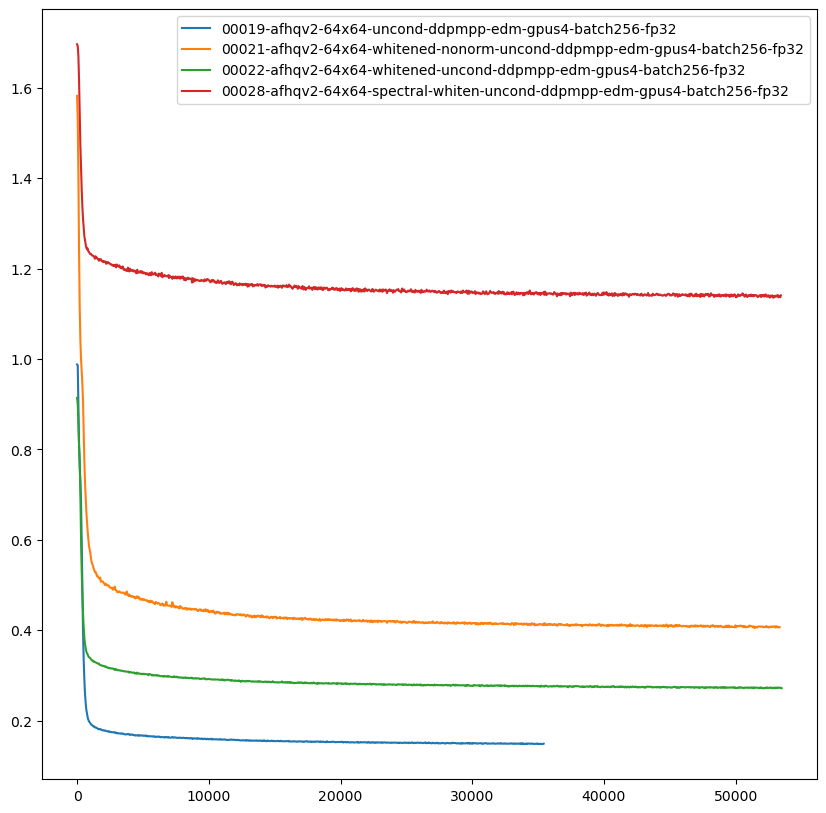

In [29]:
plt.figure(figsize=(10, 10))
for ckptdir in ['00019-afhqv2-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32',
#  '00020-ffhq-64x64-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00021-afhqv2-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00022-afhqv2-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32',
#  '00023-ffhq-64x64-whitened-uncond-ddpmpp-edm-gpus4-batch256-fp32',
#  '00024-ffhq-64x64-whitened-nonorm-uncond-ddpmpp-edm-gpus4-batch256-fp32',
 '00028-afhqv2-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32',
#  '00029-ffhq-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32'
  ]:
   train_stats = load_stats(ckptdir)
   kimg_vec = train_stats["Progress/kimg"].map(lambda x: x["mean"])
   loss_traj = train_stats["Loss/loss"].map(lambda x: x["mean"])
   plt.plot(kimg_vec, loss_traj, label=ckptdir)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Progress Kimg")
plt.show()

1066it [00:00, 12543.32it/s]


<Axes: >

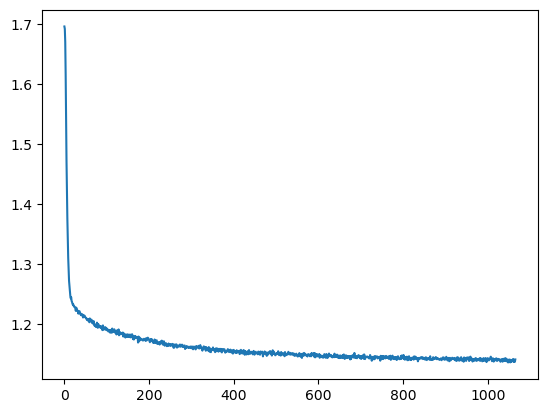

In [24]:
ckptdir = "00028-afhqv2-64x64-spectral-whiten-uncond-ddpmpp-edm-gpus4-batch256-fp32"
train_stats = load_stats(ckptdir)
train_stats["Loss/loss"].map(lambda x: x["mean"]).plot()